In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

import pandas as pd

from math import cos, asin, sqrt, pi

In [2]:
from ripser import ripser
from persim import plot_diagrams

In [3]:
data = pd.read_csv('data/weather/weatherAUS.csv')

In [4]:
geo_locations = dict({ #decimal degrees
                    'Albury': (-36.080477, 146.916280),
                    'BadgerysCreek': (-33.881667, 150.744163),
                    'Cobar': (-31.498333, 145.834444),
                    'CoffsHarbour': (-30.296241, 153.113529),
                    'Moree': (-29.461720, 149.840715),
                    'Newcastle': (-32.919295, 151.779535),
                    'NorahHead': (-33.281667, 151.567778),
                    'NorfolkIsland': (-29.028958, 167.958729),
                    'Penrith': (-33.751079, 150.694168),
                    'Richmond': (-37.820395, 145.002515),
                    'Sydney': (-33.869844, 151.208285),
                    'SydneyAirport': (-33.935309, 151.165582),
                    'WaggaWagga': (-35.115000, 147.367778),
                    'Williamtown': (-32.815000, 151.842778),
                    'Wollongong': (-34.424394, 150.893850),
                    'Canberra': (-35.297591, 149.101268),
                    'Tuggeranong': (-35.420977, 149.092134),
                    'MountGinini': (-35.529744, 148.772540),
                    'Ballarat': (-37.562303, 143.860565),
                    'Bendigo': (-36.758877, 144.282593),
                    'Sale': (-38.105036, 147.064790),
                    'MelbourneAirport': (-37.666951, 144.833493),
                    'Melbourne': (-37.814218, 144.963161),
                    'Mildura': (-34.184726, 142.162497),
                    'Nhil': (-36.333130, 141.649293),
                    'Portland': (-38.345623, 141.604230),
                    'Watsonia': (-37.711002, 145.083635),
                    'Dartmoor': (-27.996162, 115.189218),
                    'Brisbane': (-27.468968, 153.023499),
                    'Cairns': (-16.920666, 145.772185),
                    'GoldCoast': (-28.002373, 153.414599),
                    'Townsville': (-19.256939, 146.823954),
                    'Adelaide': (-34.928181, 138.599931),
                    'MountGambier': (-37.824670, 140.782007),
                    'Nuriootpa': (-34.469335, 138.993901),
                    'Woomera': (-31.199914, 136.825353),
                    'Albany': (-35.024782, 117.883608),
                    'Witchcliffe': (-34.010273, 115.115673),
                    'PearceRAAF': (-31.673960, 116.017544),
                    'PerthAirport': (-31.940610, 115.967608),
                    'Perth': (-31.955896, 115.860580),
                    'SalmonGums': (-32.981535, 121.643942),
                    'Walpole': (-34.977680, 116.731006),
                    'Hobart': (-42.882509, 147.328123),
                    'Launceston': (-41.434081, 147.137350),
                    'AliceSprings': (-23.698388, 133.881289),
                    'Darwin': (-12.460440, 130.841047),
                    'Katherine': (-14.464616, 132.263599),
                    'Uluru': (-25.345554, 131.036961)
                     })

In [5]:
data_geo = data.dropna(subset = ['Temp3pm'])[['Date', 'Location', 'Temp3pm']]

In [6]:
dates = np.unique(data_geo['Date'].values)

In [7]:
%%time
full_dates = [d for d in dates if len(data_geo[data_geo['Date'] == d]) == 49]

CPU times: user 15.6 s, sys: 0 ns, total: 15.6 s
Wall time: 15.6 s


In [8]:
k = 10 #number of observations
rs = np.random.RandomState(12345)
random_indexes = rs.randint(len(full_dates), size = (k, 1))
random_dates = np.array(full_dates)[random_indexes].flatten()

In [9]:
print(random_dates)

['2014-11-13' '2014-11-17' '2014-03-19' '2013-08-29' '2014-09-07'
 '2014-09-14' '2014-07-28' '2014-06-27' '2013-08-15' '2014-07-11']


In [10]:
vertice_labels = {i: data_geo[data_geo['Date'] == full_dates[0]]['Location'].values[i] for i in range(49)}  
signals = np.array([data_geo[data_geo['Date'] == d]['Temp3pm'].values for d in random_dates])

In [11]:
def vector_to_matrix(n, ws):
    
    W = np.zeros((n, n))
    indexes = np.triu_indices(n, k = 1)
    W[indexes] = ws
    W[indexes[::-1]] = ws
    degrees = [sum(W[i]) for i in range(n)]
    
    return W, degrees

def objective_function_spielman(x, ws):
    
    n, d = np.shape(x)
    W, ds = vector_to_matrix(np.shape(x)[0], ws)
    L = np.diag(ds) - W
    
    return np.linalg.norm(L @ x)

def constraints_spielman(n, c, α):
    
    _, ds = vector_to_matrix(n, c)
    g = lambda c: α * n - sum([max(0, 1 - di) for di in ds]) 
#     g = lambda c: sum([max(0, 1 - di) for di in ds]) - α * n 
    return ({'type': 'ineq', 'fun': g})

def bounds_spielman(n):
    
    return n * [(0, None)]

In [12]:
x = signals.T

n, d = np.shape(x)

L0 = np.arange(0, n ** 2, 1).reshape((n, n))/100
# L0 = 0.000005 * np.ones((n, n))
ws = L0[np.triu_indices(np.shape(x)[0], k = 1)]

g = lambda ws: objective_function_spielman(x, ws)

In [13]:
%%time
α = 0.1
t = 8
res = minimize(g, ws, bounds = bounds_spielman(len(ws)), constraints = constraints_spielman(n, ws, α), 
               tol = 1 * 10 ** (-t))

CPU times: user 5min 39s, sys: 78.1 ms, total: 5min 39s
Wall time: 5min 40s


In [14]:
def make_graph(n, ws, tol = 10):
    
    new_ws = np.round(ws, tol)
    W = np.zeros((n, n))
    W[np.triu_indices(n, 1)] = new_ws
    for i in range(1, n):
        for j in range(i):
            W[i, j] = W[j, i]
    return p.graphs.Graph(W)

In [15]:
L = make_graph(np.shape(x)[0], res.x, tol = t)
L.set_coordinates([[geo_locations[vertice_labels[i]][1], geo_locations[vertice_labels[i]][0]] for i in range(49)])

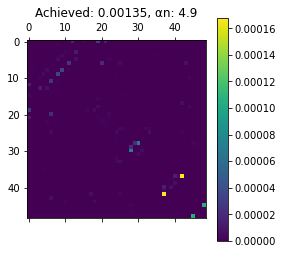

In [16]:
plt.matshow(L.W.todense())
plt.colorbar()
plt.title('Achieved: ' + str(np.round(np.trace(L.L.todense()), 5)) + ', αn: ' + str(α * np.shape(x)[0]))
plt.show()

In [17]:
L.compute_fourier_basis()

In [18]:
W = L.W.todense()
ns = [list(n) for n in np.array(np.nonzero(W > 0)).T]

In [19]:
neighbors = dict()
for n in ns:
    i, j = n
    if(vertice_labels[i] in neighbors.keys()):
        neighbors[vertice_labels[i]].append(vertice_labels[j])
    else:
        neighbors[vertice_labels[i]] = [vertice_labels[j]]

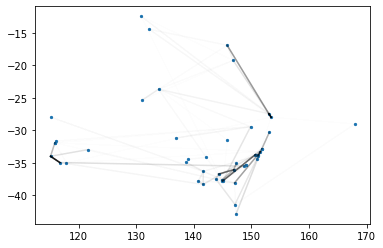

In [20]:
plt.scatter([geo_locations[vertice_labels[i]][1] for i in range(49)], [geo_locations[vertice_labels[i]][0] for i in range(49)], s = 5)
for place in neighbors.keys():
    edges = neighbors[place]
    i = list(vertice_labels.values()).index(place)
    for e in edges:
        j = list(vertice_labels.values()).index(e)
        plt.plot([geo_locations[place][1], geo_locations[e][1]], [geo_locations[place][0], geo_locations[e][0]], color = 'black', alpha = 1e4 * W[i,j])

In [21]:
def great_circle_distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...

In [22]:
distance_weight_ratio = {}
for place1 in neighbors.keys():
    i = list(vertice_labels.values()).index(place1)
    for place2 in neighbors[place1]:
        j = list(vertice_labels.values()).index(place2)
        dist = great_circle_distance(*geo_locations[place1], *geo_locations[place2])
        w = L.W[i, j]
        if w == 0:
            print(place1, i, place2, j)
        if place1 not in distance_weight_ratio.keys():
            distance_weight_ratio[place1] = [dist * w]
        else:
            distance_weight_ratio[place1].append(dist * w)            

In [23]:
def get_index(place):
    return list(vertice_labels.values()).index(place)

In [24]:
max(max(list(distance_weight_ratio.values())))

0.03045717164639072

In [25]:
#NorahHead, Richmond, MountGinini, Sale, Cairns, Walpole, AliceSprings, Uluru tem ratios approx 1e-2

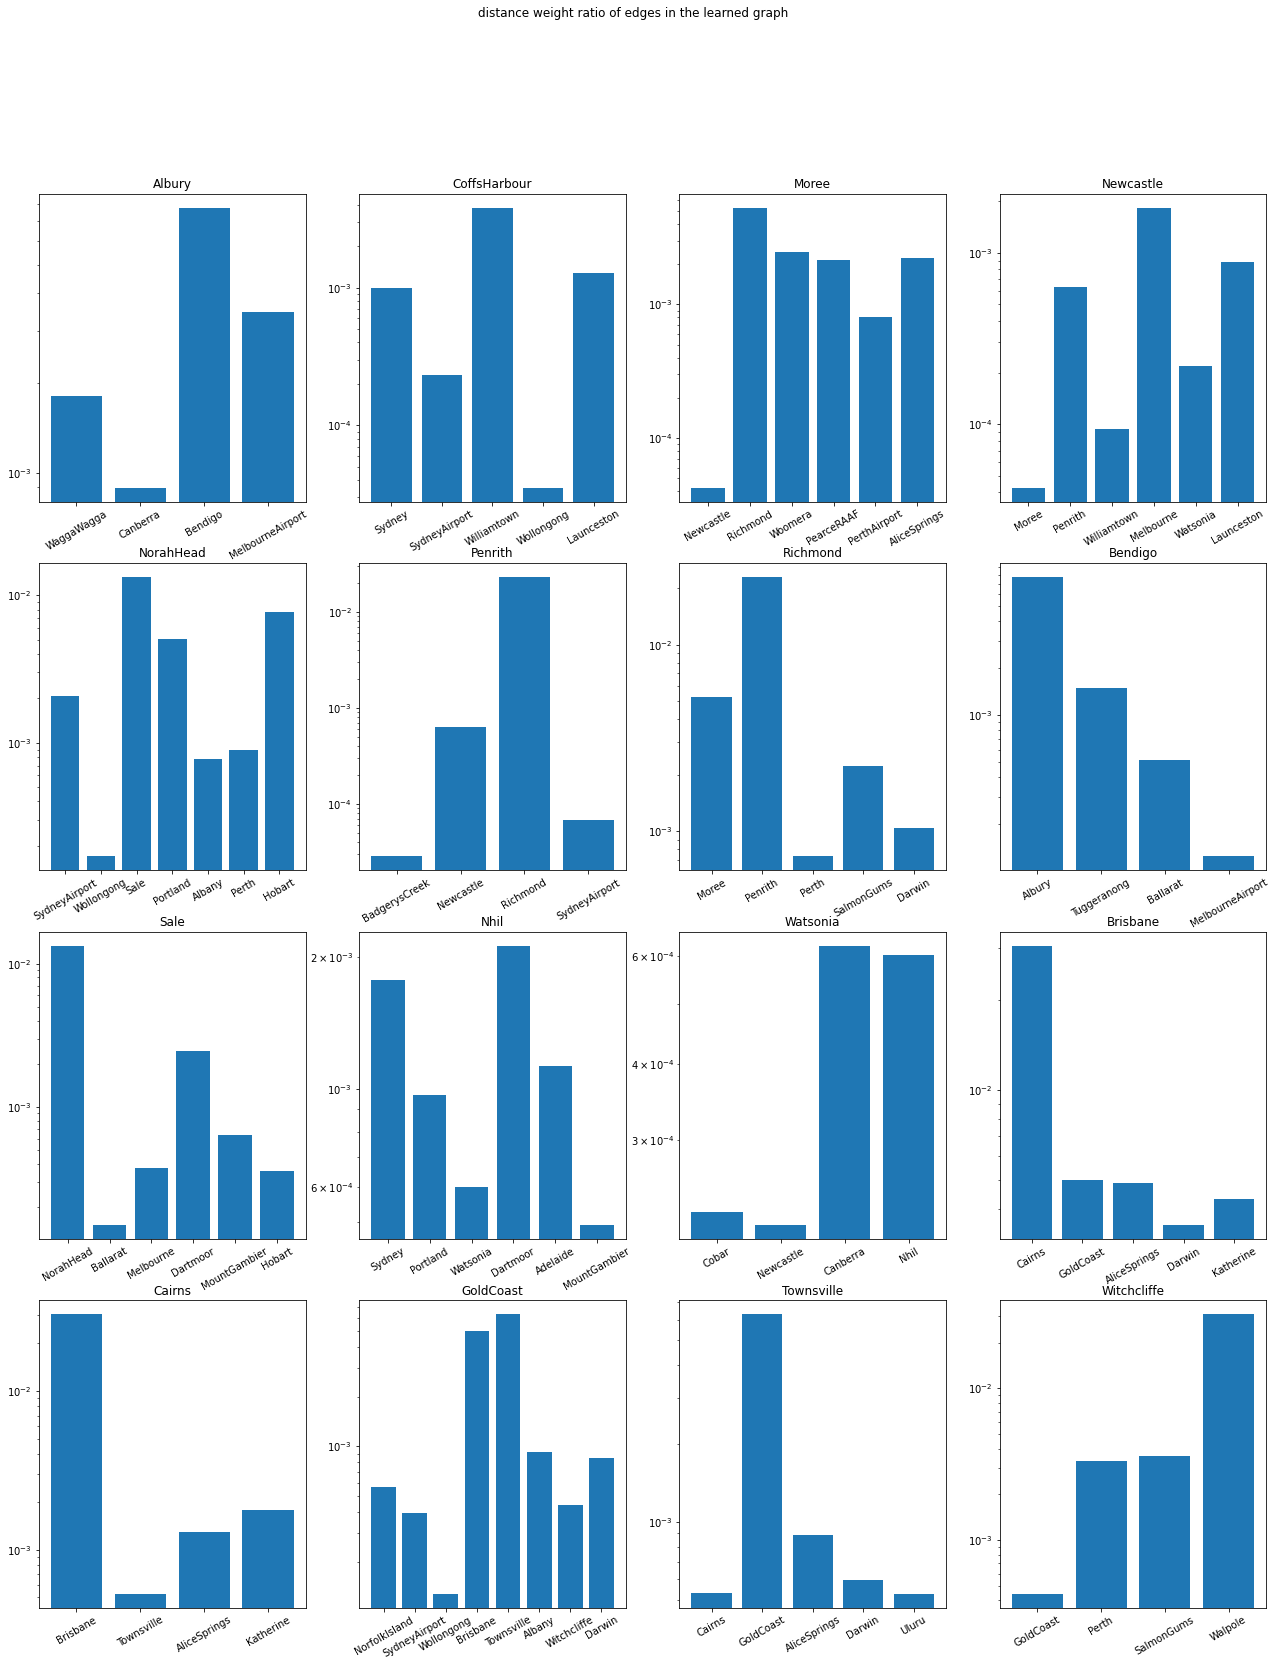

In [26]:
indexes = [0, 3, 4, 5, 6, 8, 9, 19, 20, 24, 26, 28, 29, 30, 31, 37, 38]
places = [vertice_labels[i] for i in indexes]

fig, ax = plt.subplots(4, 4, figsize = (22, 26))
for i in range(4):
    for j in range(4):
        ax[i][j].set_title(places[4 * i + j])
        ax[i][j].bar(np.arange(len(distance_weight_ratio[places[4 * i + j]])), distance_weight_ratio[places[4 * i + j]])
        ax[i][j].set_xticks(np.arange(0, len(neighbors[places[4 * i + j]])))
        ax[i][j].set_xticklabels(neighbors[places[4 * i + j]], rotation = 30)
        ax[i][j].set_yscale('log')
        
fig.suptitle('distance weight ratio of edges in the learned graph')
plt.show()

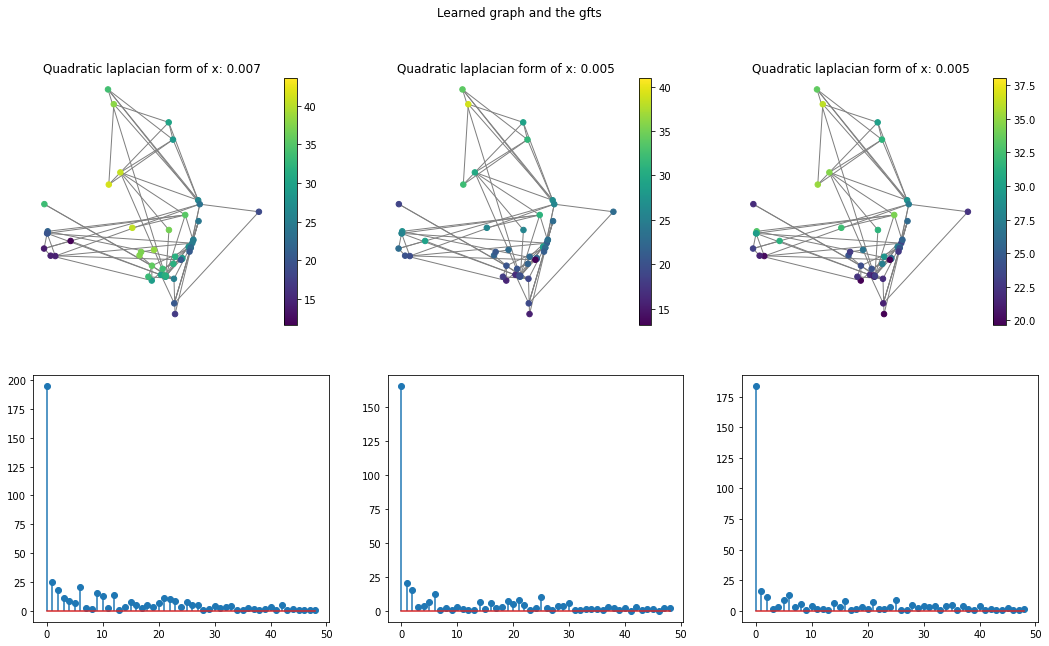

In [27]:
fig, ax = plt.subplots(2, 3, figsize = (18, 10))


for i in [0,1,2]:
    L.plot_signal(x.T[i], ax=ax[0][i], vertex_size = 30)
    ax[1][i].stem(np.abs(L.gft(x.T[i])))
    ax[0][i].axis('off')
#     ax[1][i].axis('off')
    ax[0][i].set_title('Quadratic laplacian form of x: ' + str(np.round(x[:, i] @ (L.L) @ x[:, i], 3)))
#     ax[1][i].set_title(y[:, i] @ H.L @ y[:, i])

plt.suptitle('Learned graph and the gfts')
plt.show()

In [28]:
L.is_connected()

True

In [29]:
date = '2015-10-15'
missing_temperatures = {'Newcastle': 26.1, 'Melbourne': 34, 'Albany': 14, 'Katherine': 36.5} 
#Melbourne entre 29-34, Albany entre 14 e 17 e Katherine entre 35 e 38